In [1]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc

Mounted at /content/drive


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error as MSE
from math import sqrt
plt.style.use('ggplot')
%matplotlib inline
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import itertools
from matplotlib.pylab import rcParams
plt.style.use('ggplot')
import statsmodels.api as sm
import matplotlib as mpl
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc
from scipy.spatial.distance import euclidean
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, make_scorer
from sklearn.tree import export_graphviz
from IPython.display import Image
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
#df=pd.read_csv('data/8countries/top200_processed2.csv')
df=pd.read_csv('/content/drive/MyDrive/ML-Project/data/9countries/top200_9countries_processed.csv')
df.head()

,Unnamed: 0,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,title,rank,date,region,trend,streams,year,month,top200_count,trend_rank_score,stream_bins
0,0,76,0.620,0.936,7,-4.593,1,0.0308,0.0261,0.00000,0.0679,0.763,97.527,2.929117,4,You Can't Hurry Love - 2016 Remaster - United ...,199,2017-01-01,United States,NEW_ENTRY,143813.0,2017,1,1,0.010,1
1,1,0,0.725,0.853,2,-7.842,1,0.0353,0.0348,0.12700,0.1960,0.904,136.282,3.713550,4,(I Can't Get No) Satisfaction - Mono Version /...,193,2017-01-01,United States,NEW_ENTRY,144843.0,2017,1,1,0.040,1
2,7,0,0.572,0.786,8,-8.469,1,0.0642,0.5190,0.00093,0.1100,0.952,188.115,2.914450,4,ABC - United States,186,2017-01-01,United States,NEW_ENTRY,148305.0,2017,1,1,0.075,1
3,12,3,0.647,0.822,5,-4.662,0,0.1830,0.2190,0.00000,0.0908,0.962,160.019,3.878667,4,"Happy - From ""Despicable Me 2"" - United States",80,2017-01-01,United States,MOVE_UP,233169.0,2017,1,1,0.605,3
4,13,76,0.776,0.763,5,-8.124,1,0.0534,0.1820,0.00647,0.0770,0.820,128.433,4.666667,4,You Can Call Me Al - United States,125,2017-01-01,United States,NEW_ENTRY,183669.0,2017,1,1,0.380,1


In [4]:
df.columns

Index(['Unnamed: 0', 'popularity', 'danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'time_signature', 'title', 'rank',
       'date', 'region', 'trend', 'streams', 'year', 'month', 'top200_count',
       'trend_rank_score', 'stream_bins'],
      dtype='object')

In [5]:
df=df.drop(['Unnamed: 0','time_signature','title','trend','date','streams'],axis=1)

In [6]:
df.head(5)

,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,rank,region,year,month,top200_count,trend_rank_score,stream_bins
0,76,0.620,0.936,7,-4.593,1,0.0308,0.0261,0.00000,0.0679,0.763,97.527,2.929117,199,United States,2017,1,1,0.010,1
1,0,0.725,0.853,2,-7.842,1,0.0353,0.0348,0.12700,0.1960,0.904,136.282,3.713550,193,United States,2017,1,1,0.040,1
2,0,0.572,0.786,8,-8.469,1,0.0642,0.5190,0.00093,0.1100,0.952,188.115,2.914450,186,United States,2017,1,1,0.075,1
3,3,0.647,0.822,5,-4.662,0,0.1830,0.2190,0.00000,0.0908,0.962,160.019,3.878667,80,United States,2017,1,1,0.605,3
4,76,0.776,0.763,5,-8.124,1,0.0534,0.1820,0.00647,0.0770,0.820,128.433,4.666667,125,United States,2017,1,1,0.380,1


In [7]:
#encoding region and years
regions=list(df['region'].unique())
years=list(df['year'].unique())
df['enc_region']=df['region'].apply(lambda x:regions.index(x))
df['enc_year']=df['year'].apply(lambda x:years.index(x))


In [8]:
df=df.drop(['region','year'],axis=1)

In [9]:
df[df.isna().any(axis=1)]

,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,rank,month,top200_count,trend_rank_score,stream_bins,enc_region,enc_year


In [10]:
df.dropna(inplace=True)

In [11]:
y = df['stream_bins']
X = df.drop('stream_bins', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42, test_size=0.2)

In [12]:
#Decision tree
dt = DecisionTreeClassifier(criterion='entropy', random_state=42)
dt.fit(X_train, y_train)
# Make predictions using test set 
y_pred = dt.predict(X_test)
# Check the AUC of predictions
print(metrics.confusion_matrix(y_test, y_pred))

[[2270  521  179   25]
 [ 454 1563  754  133]
 [ 141  727 1486  562]
 [  20  139  559 2149]]


In [13]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.79      0.76      0.77      2995
           2       0.53      0.54      0.53      2904
           3       0.50      0.51      0.50      2916
           4       0.75      0.75      0.75      2867

    accuracy                           0.64     11682
   macro avg       0.64      0.64      0.64     11682
weighted avg       0.64      0.64      0.64     11682



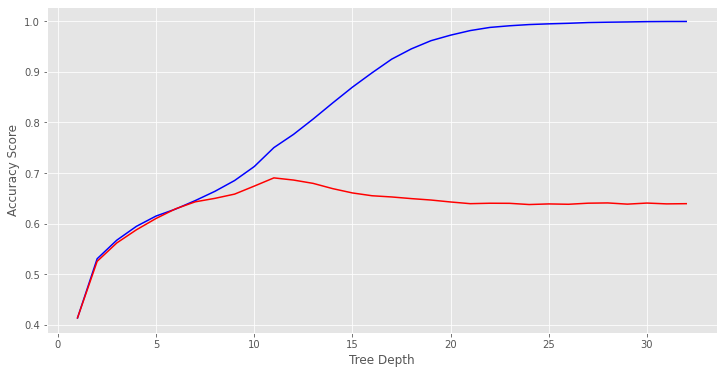

In [14]:
max_depths = np.linspace(1,32,32,endpoint=True)
# As review, linspace returns evenly spaced numbers over a specified interval.
train_results=[]
test_results=[]
for max_depth in max_depths:
    dt = DecisionTreeClassifier(criterion='entropy', max_depth=max_depth, random_state=42)
    dt.fit(X_train, y_train)
    train_pred = dt.predict(X_train)
    #false_positive_rate, true_positive_rate, thresholds = metrics.auc(y_train, train_pred)
    auc = metrics.accuracy_score(y_train, train_pred)
    # add auc score to the previous train results
    train_results.append(auc)
    y_pred = dt.predict(X_test)
    #false_positive_rate, true_positive_rate, thresholds=roc_curve(y_test, y_pred)
    auc = metrics.accuracy_score(y_test, y_pred)
    # add score to previous test results
    test_results.append(auc)
plt.figure(figsize=(12,6))
plt.plot(max_depths, train_results, 'b', label='Train AUC')
plt.plot(max_depths, test_results, 'r', label='Test AUC')
plt.ylabel('Accuracy Score')
plt.xlabel('Tree Depth')
plt.legend
plt.show()

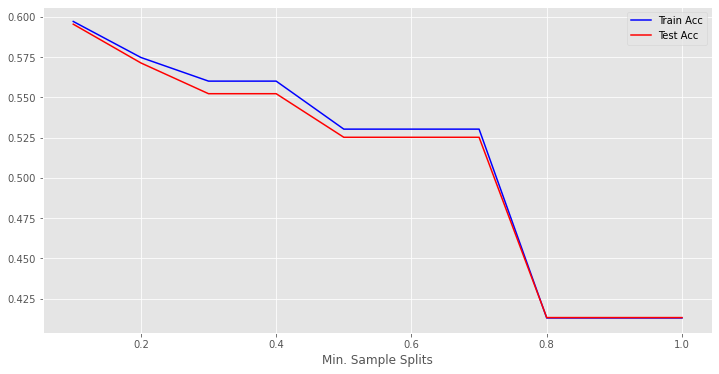

In [15]:
min_samples_splits = np.linspace(0.1,1.0,10, endpoint=True)
train_results = []
test_results = []
for min_samples_split in min_samples_splits:
    dt = DecisionTreeClassifier (criterion = 'entropy', min_samples_split = min_samples_split, random_state=42)
    dt.fit(X_train, y_train)
    train_pred = dt.predict(X_train)
    #false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    acc = metrics.accuracy_score(y_train, train_pred)
    train_results.append(acc)
    y_pred = dt.predict(X_test)
    #false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    acc = metrics.accuracy_score(y_test, y_pred)
    test_results.append(acc)
plt.figure(figsize=(12,6))
plt.plot(min_samples_splits, train_results, 'b', label = 'Train Acc')
plt.plot(min_samples_splits, test_results, 'r',label = 'Test Acc')
plt.xlabel('Min. Sample Splits')
plt.legend()
plt.show()

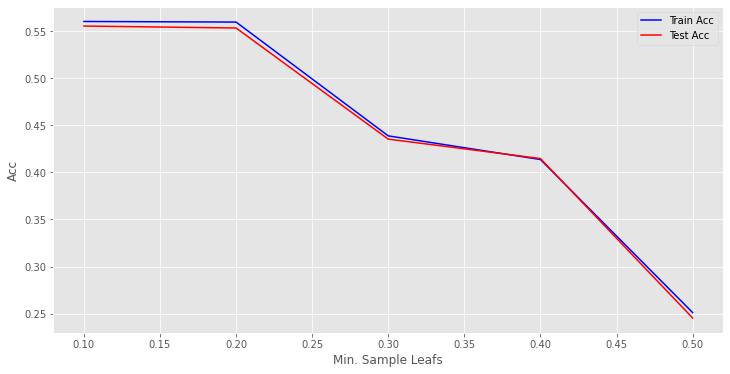

In [16]:
# Calculate the optimal value for minimum sample leafs
min_samples_leafs=np.linspace(0.1,0.5,5, endpoint = True)
train_results=[]
test_results=[]
for min_samples_leaf in min_samples_leafs:
    dt = DecisionTreeClassifier(criterion='entropy', min_samples_leaf = min_samples_leaf, random_state=42)
    dt.fit(X_train, y_train)
    train_pred = dt.predict(X_train)
    #false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    acc = metrics.accuracy_score(y_train, train_pred)
    train_results.append(acc)
    y_pred = dt.predict(X_test)
    #false_positive_rate, true_positive_rate, thresholds = roc_curve (y_test, y_pred)
    acc = metrics.accuracy_score(y_test, y_pred)
    test_results.append(acc)
plt.figure(figsize=(12,6))
plt.plot(min_samples_leafs, train_results, 'b', label='Train Acc')
plt.plot(min_samples_leafs, test_results, 'r', label='Test Acc')
plt.ylabel('Acc')
plt.xlabel('Min. Sample Leafs')
plt.legend()
plt.show()

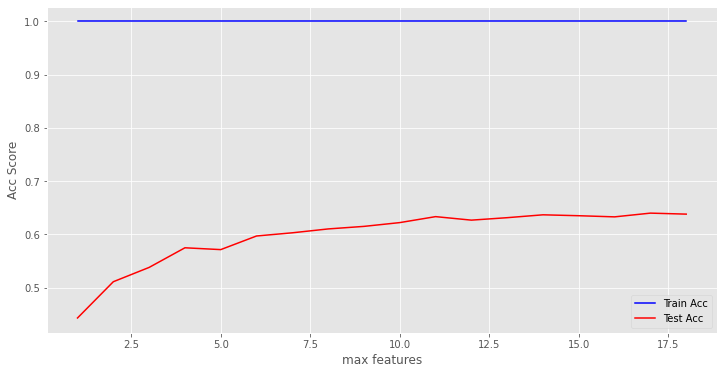

In [17]:
max_features = list(range(1, X_train.shape[1]))
train_results = []
test_results = []
for max_feature in max_features:
    dt = DecisionTreeClassifier(criterion = 'entropy', max_features = max_feature, random_state=42)
    dt.fit(X_train, y_train)
    train_pred = dt.predict(X_train)
    #false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    acc = metrics.accuracy_score(y_train, train_pred)
    train_results.append(acc)
    y_pred = dt.predict(X_test)
    #false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    acc = metrics.accuracy_score(y_test, y_pred)
    test_results.append(acc)
plt.figure(figsize=(12,6))
plt.plot(max_features, train_results, 'b', label = 'Train Acc')
plt.plot(max_features, test_results, 'r', label = 'Test Acc')
plt.ylabel('Acc Score')
plt.xlabel('max features')
plt.legend()
plt.show()

In [18]:
dt2 = DecisionTreeClassifier(criterion='entropy',
                           max_features=15,
                           max_depth = 8,
                           min_samples_split = 0.1,
                           min_samples_leaf = 0.1,
                           random_state = 42)

dt2.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=8, max_features=15,
                       min_samples_leaf=0.1, min_samples_split=0.1,
                       random_state=42)

In [19]:
y_pred = dt2.predict(X_test)
# Calculate accuracy 
acc = accuracy_score(y_test, y_pred) * 100
print('Accuracy is: {0}'.format(acc))
# Create and print a confusion matrix 
print('\nConfusion Matrix')
print('----------------')
pd.crosstab(y_test,y_pred,rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy is: 55.52987502140044

Confusion Matrix
----------------


Predicted,1,2,3,4,All
True,,,,,
1,2072,385,246,292,2995
2,722,969,877,336,2904
3,263,617,1321,715,2916
4,79,94,569,2125,2867
All,3136,2065,3013,3468,11682


In [20]:
# Confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[2072  385  246  292]
 [ 722  969  877  336]
 [ 263  617 1321  715]
 [  79   94  569 2125]]
              precision    recall  f1-score   support

           1       0.66      0.69      0.68      2995
           2       0.47      0.33      0.39      2904
           3       0.44      0.45      0.45      2916
           4       0.61      0.74      0.67      2867

    accuracy                           0.56     11682
   macro avg       0.55      0.55      0.55     11682
weighted avg       0.55      0.56      0.55     11682



In [21]:
import graphviz
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')


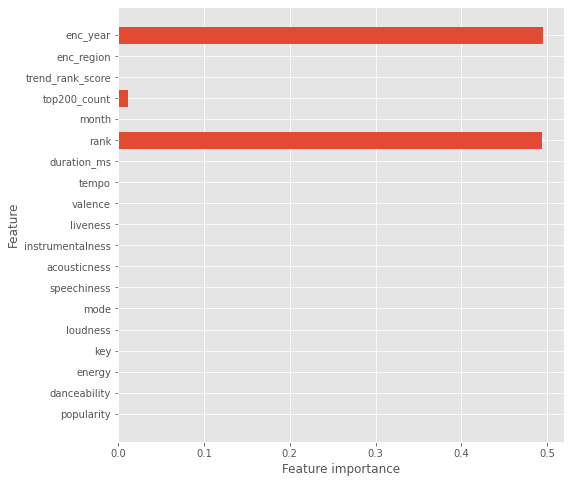

In [22]:
plot_feature_importances(dt2)

In [23]:
# Instantiate StandardScaler
scaler = StandardScaler()

# Transform the training and test sets
scaled_data_train = scaler.fit_transform(X_train)
scaled_data_test = scaler.fit_transform(X_test)

# Convert into a DataFrame
scaled_df_train = pd.DataFrame(scaled_data_train, columns=X.columns)
scaled_df_train.head()

,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,rank,month,top200_count,trend_rank_score,enc_region,enc_year
0,-0.317119,0.287068,0.355382,0.753186,-0.019221,0.895642,-0.681441,-0.843922,-0.169105,-0.502691,0.738320,0.978734,-0.316170,0.725143,0.984164,1.153201,1.206157,1.131677,0.621995
1,0.109340,0.165838,-0.231909,-0.344422,-0.332413,0.895642,0.854639,0.960837,-0.169105,-0.322704,-1.000373,-1.611655,-0.785781,-0.042074,-0.476616,-0.441743,-0.407225,-1.532335,-0.795008
2,0.574567,-1.625674,1.148226,0.753186,0.642341,0.895642,-0.714441,-0.648356,-0.169105,1.019697,-0.622594,1.692174,-0.349139,0.497819,0.984164,-0.450137,-0.417744,-1.151762,0.621995
3,1.233638,-0.622158,-1.206813,-0.070020,0.254255,-1.116517,-0.846442,0.365287,-0.169105,-0.679678,-0.895687,-1.504122,1.855578,-0.752461,0.984164,0.414491,0.127240,-0.771189,1.330497
4,-0.510963,-0.319083,1.729645,-0.070020,0.575390,0.895642,-0.831513,-0.905891,-0.169088,-0.285207,-0.900239,-0.026958,0.063863,0.355742,0.107696,-0.416559,-0.388475,1.131677,-1.503509


In [24]:
# Instantiate KNeighborsClassifier
clf = KNeighborsClassifier()

# Fit the classifier
clf.fit(scaled_data_train, y_train)

# Predict on the test set
test_preds = clf.predict(scaled_data_test)

In [25]:
print(confusion_matrix(y_test, test_preds))
print(classification_report(y_test, test_preds))

[[2001  629  311   54]
 [ 782 1242  722  158]
 [ 473 1035 1054  354]
 [ 151  464  641 1611]]
              precision    recall  f1-score   support

           1       0.59      0.67      0.63      2995
           2       0.37      0.43      0.40      2904
           3       0.39      0.36      0.37      2916
           4       0.74      0.56      0.64      2867

    accuracy                           0.51     11682
   macro avg       0.52      0.50      0.51     11682
weighted avg       0.52      0.51      0.51     11682



In [26]:
def find_best_k(X_train, y_train, X_test, y_test, min_k=1, max_k=34):
    best_k = 0
    best_score = 0.0
    for k in range (min_k, max_k+1, 2):
        knn = KNeighborsClassifier(n_neighbors = k)
        knn.fit(X_train, y_train)
        preds = knn.predict(X_test)
        f1 = f1_score (y_test, preds, average='micro')
        if f1 > best_score:
            best_k = k
            best_score = f1
    print ("Best value for k: {}".format(best_k))
    print ("F1-Score: {}".format(best_score))

In [27]:
find_best_k(scaled_data_train, y_train, scaled_data_test, y_test)

Best value for k: 31
F1-Score: 0.5600068481424414


In [28]:
# Instantiate KNeighborsClassifier
clf2 = KNeighborsClassifier(n_neighbors=33)

# Fit the classifier
clf2.fit(scaled_data_train, y_train)

# Predict on the test set
test_preds = clf2.predict(scaled_data_test)

In [29]:
print(confusion_matrix(y_test, test_preds))
print(classification_report(y_test, test_preds))

[[2101  524  323   47]
 [ 647 1297  826  134]
 [ 334  875 1336  371]
 [ 107  294  668 1798]]
              precision    recall  f1-score   support

           1       0.66      0.70      0.68      2995
           2       0.43      0.45      0.44      2904
           3       0.42      0.46      0.44      2916
           4       0.77      0.63      0.69      2867

    accuracy                           0.56     11682
   macro avg       0.57      0.56      0.56     11682
weighted avg       0.57      0.56      0.56     11682



In [30]:
#Random forest
# Instantiate a BaggingClassifier
bagged_tree = BaggingClassifier(DecisionTreeClassifier(criterion='entropy', max_depth=5), 
                                 n_estimators=20)

In [31]:
# Fit to the training data
bagged_tree.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy',
                                                        max_depth=5),
                  n_estimators=20)

In [32]:
# Training accuracy score
bagged_tree.score(X_train, y_train)

0.6258747993579454

In [33]:
# Test accuracy score
bagged_tree.score(X_test, y_test)

0.6223249443588427

In [34]:
# Test set predictions
pred = bagged_tree.predict(X_test)

# Confusion matrix and classification report
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

[[2164  623  166   42]
 [ 454 1659  652  139]
 [ 188  966 1275  487]
 [  58  170  467 2172]]
              precision    recall  f1-score   support

           1       0.76      0.72      0.74      2995
           2       0.49      0.57      0.52      2904
           3       0.50      0.44      0.47      2916
           4       0.76      0.76      0.76      2867

    accuracy                           0.62     11682
   macro avg       0.63      0.62      0.62     11682
weighted avg       0.63      0.62      0.62     11682



In [35]:
# Instantiate and fit a RandomForestClassifier
forest = RandomForestClassifier(n_estimators=100, max_depth=6)
forest.fit(X_train, y_train)

RandomForestClassifier(max_depth=6)

In [36]:
# Training accuracy score
forest.score(X_train, y_train)

0.6215516318887105

In [37]:
# Test accuracy score
forest.score(X_test, y_test)

0.6111967128916281

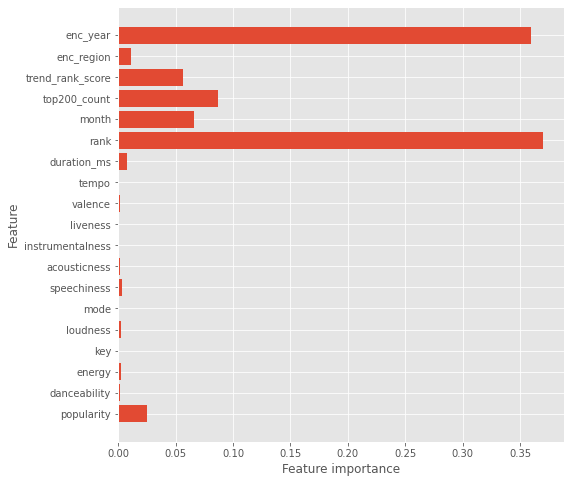

In [38]:
plot_feature_importances(forest)

In [39]:
# Test set predictions for forest:
pred = forest.predict(X_test)

# Confusion matrix and classification report
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

[[2271  506  146   72]
 [ 699 1408  590  207]
 [ 262  881 1250  523]
 [  59  132  465 2211]]
              precision    recall  f1-score   support

           1       0.69      0.76      0.72      2995
           2       0.48      0.48      0.48      2904
           3       0.51      0.43      0.47      2916
           4       0.73      0.77      0.75      2867

    accuracy                           0.61     11682
   macro avg       0.60      0.61      0.61     11682
weighted avg       0.60      0.61      0.61     11682



In [40]:
#GridSearch random forest
rf_clf = RandomForestClassifier()
mean_rf_cv_score = np.mean(cross_val_score(rf_clf, X_train, y_train, cv=3))

print(f"Mean Cross Val Score for Random Forest Classifier: {mean_rf_cv_score :.2%}")

Mean Cross Val Score for Random Forest Classifier: 66.90%


In [41]:
rf_param_grid = {
    'n_estimators' : [10,30,100],
    'criterion' : ['gini', 'entropy'],
    'max_depth' : [None, 2,6,10],
    'min_samples_split' : [5,10],
    'min_samples_leaf' : [3,6]
    
}

In [42]:
rf_grid_search = GridSearchCV(rf_clf, rf_param_grid, cv=3)
rf_grid_search.fit(X_train, y_train)


print(f"Testing Accuracy: {rf_grid_search.best_score_ :.2%}")
print("")
print(f"Optimal Parameters: {rf_grid_search.best_params_}")

Testing Accuracy: 67.67%

Optimal Parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 100}


In [43]:
forest2 = RandomForestClassifier(n_estimators=100, max_depth=None, 
                                criterion = 'entropy', min_samples_leaf=3,
                                min_samples_split=5)
forest2.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', min_samples_leaf=3,
                       min_samples_split=5)

In [44]:
# Training accuracy score
forest2.score(X_train, y_train)

0.9779347244515784

In [45]:
# Test accuracy score
forest2.score(X_test, y_test)

0.6878959082348913

In [46]:
# Test set predictions for final forest:
pred = forest2.predict(X_test)

# Confusion matrix and classification report
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

[[2312  521  128   34]
 [ 412 1757  624  111]
 [ 137  636 1713  430]
 [  22   64  527 2254]]
              precision    recall  f1-score   support

           1       0.80      0.77      0.79      2995
           2       0.59      0.61      0.60      2904
           3       0.57      0.59      0.58      2916
           4       0.80      0.79      0.79      2867

    accuracy                           0.69     11682
   macro avg       0.69      0.69      0.69     11682
weighted avg       0.69      0.69      0.69     11682



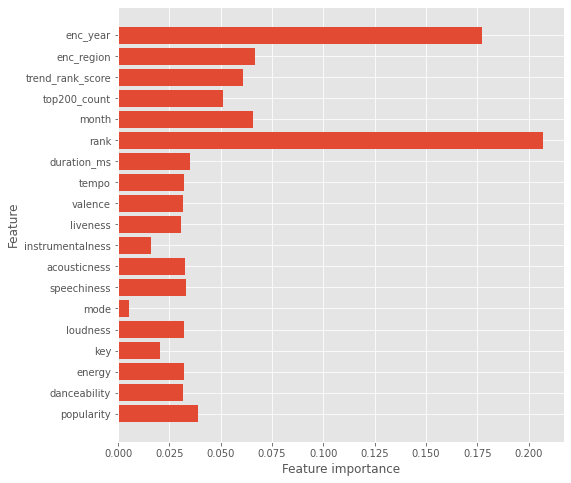

In [47]:
plot_feature_importances(forest2)

In [48]:
#using the more importantfeatures - remove mode, key, instrumentalness
X = df[['enc_year','enc_region','trend_rank_score','top200_count','month','rank','popularity', 'duration_ms','valence',
        'danceability','tempo', 'liveness', 'acousticness', 'speechiness','loudness','energy']]

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42, test_size=0.2)

In [50]:
#untuned decision tree
dt4 = DecisionTreeClassifier(criterion='entropy', random_state=42)
dt4.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=42)

In [51]:
# Make predictions using test set 
y_pred = dt4.predict(X_test)

# Check the AUC of predictions
print(metrics.accuracy_score(y_test, y_pred))

0.6387604862181133


In [52]:
# Confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[2246  566  156   27]
 [ 453 1578  746  127]
 [ 145  717 1498  556]
 [  17  128  582 2140]]
              precision    recall  f1-score   support

           1       0.79      0.75      0.77      2995
           2       0.53      0.54      0.54      2904
           3       0.50      0.51      0.51      2916
           4       0.75      0.75      0.75      2867

    accuracy                           0.64     11682
   macro avg       0.64      0.64      0.64     11682
weighted avg       0.64      0.64      0.64     11682



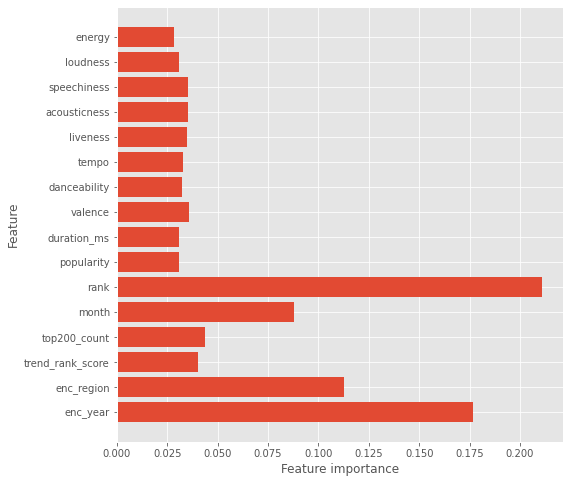

In [53]:
plot_feature_importances(dt4)

In [54]:
# Instantiate a BaggingClassifier
bagged_tree2 = BaggingClassifier(DecisionTreeClassifier(criterion='entropy', max_depth=5), 
                                 n_estimators=20)

In [55]:
# Fit to the training data
bagged_tree2.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy',
                                                        max_depth=5),
                  n_estimators=20)

In [56]:
# Training accuracy score
bagged_tree2.score(X_train, y_train)

0.6252541466024613

In [57]:
# Test accuracy score
bagged_tree2.score(X_test, y_test)

0.6228385550419449

In [58]:
# Test set predictions
pred = bagged_tree2.predict(X_test)

# Confusion matrix and classification report
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

[[2168  607  157   63]
 [ 471 1624  623  186]
 [ 184  947 1276  509]
 [  37  140  482 2208]]
              precision    recall  f1-score   support

           1       0.76      0.72      0.74      2995
           2       0.49      0.56      0.52      2904
           3       0.50      0.44      0.47      2916
           4       0.74      0.77      0.76      2867

    accuracy                           0.62     11682
   macro avg       0.62      0.62      0.62     11682
weighted avg       0.62      0.62      0.62     11682



In [59]:
#untuned random forest
# Instantiate and fit an Untuned RandomForestClassifier
forest3 = RandomForestClassifier(n_estimators=100, max_depth=6)
forest3.fit(X_train, y_train)

RandomForestClassifier(max_depth=6)

In [60]:
forest3.score(X_train, y_train)

0.6273729266987694

In [61]:
forest3.score(X_test, y_test)

0.620612908748502

In [62]:
# Test set predictions
pred = forest3.predict(X_test)

# Confusion matrix and classification report
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

[[2272  524  133   66]
 [ 683 1477  547  197]
 [ 252  865 1280  519]
 [  47  128  471 2221]]
              precision    recall  f1-score   support

           1       0.70      0.76      0.73      2995
           2       0.49      0.51      0.50      2904
           3       0.53      0.44      0.48      2916
           4       0.74      0.77      0.76      2867

    accuracy                           0.62     11682
   macro avg       0.61      0.62      0.62     11682
weighted avg       0.61      0.62      0.62     11682



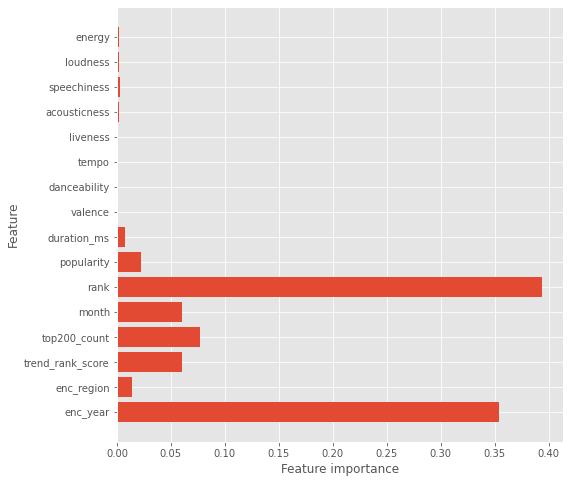

In [63]:
plot_feature_importances(forest3)

In [64]:
dt_clf2 = DecisionTreeClassifier()
dt_cv_score = cross_val_score(dt_clf2, X_train, y_train, cv=3) 
mean_dt_cv_score = np.mean(dt_cv_score)

print(f"Mean Cross Validation Score: {mean_dt_cv_score :.2%}")

Mean Cross Validation Score: 63.26%


In [65]:
dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 3, 4, 5, 6],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6]
}

In [66]:
# Instantiate GridSearchCV
dt_grid_search = GridSearchCV(dt_clf2, dt_param_grid, cv=3, return_train_score=True)

# Fit to the data
dt_grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 2, 3, 4, 5, 6],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6],
                         'min_samples_split': [2, 5, 10]},
             return_train_score=True)

In [67]:
# Mean training score
dt_gs_training_score = np.mean(dt_grid_search.cv_results_['mean_train_score'])

# Mean test score
dt_gs_testing_score = dt_grid_search.score(X_test, y_test)

print(f"Mean Training Score: {dt_gs_training_score :.2%}")
print(f"Mean Test Score: {dt_gs_testing_score :.2%}")
print("Best Parameter Combination Found During Grid Search:")
dt_grid_search.best_params_

Mean Training Score: 63.95%
Mean Test Score: 66.38%
Best Parameter Combination Found During Grid Search:


{'criterion': 'gini',
 'max_depth': None,
 'min_samples_leaf': 6,
 'min_samples_split': 2}

In [68]:
tree_clf3 = DecisionTreeClassifier(criterion='gini', max_depth=None, min_samples_leaf = 6,
                                  min_samples_split = 5)
tree_clf3.fit(X_train, y_train)

DecisionTreeClassifier(min_samples_leaf=6, min_samples_split=5)

In [69]:
# Test set predictions for tree:
pred = tree_clf3.predict(X_test)

# Confusion matrix and classification report
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

[[2354  477  146   18]
 [ 456 1677  661  110]
 [ 120  722 1608  466]
 [  17  125  602 2123]]
              precision    recall  f1-score   support

           1       0.80      0.79      0.79      2995
           2       0.56      0.58      0.57      2904
           3       0.53      0.55      0.54      2916
           4       0.78      0.74      0.76      2867

    accuracy                           0.66     11682
   macro avg       0.67      0.66      0.67     11682
weighted avg       0.67      0.66      0.67     11682



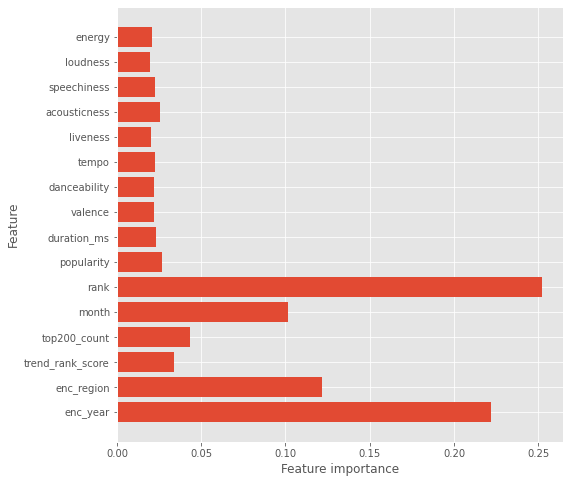

In [70]:
plot_feature_importances(tree_clf3)

In [71]:
forest4 = RandomForestClassifier()
mean_rf_cv_score = np.mean(cross_val_score(forest4, X_train, y_train, cv=3))

print(f"Mean Cross Val Score for Random Forest Classifier: {mean_rf_cv_score :.2%}")

Mean Cross Val Score for Random Forest Classifier: 68.06%


In [72]:
rf_param_grid = {
    'n_estimators' : [10,30,100],
    'criterion' : ['gini', 'entropy'],
    'max_depth' : [None, 2,6,10],
    'min_samples_split' : [5,10],
    'min_samples_leaf' : [3,6]
    
}

In [73]:
rf_grid_search = GridSearchCV(forest4, rf_param_grid, cv=3)
rf_grid_search.fit(X_train, y_train)


print(f"Testing Accuracy: {rf_grid_search.best_score_ :.2%}")
print("")
print(f"Optimal Parameters: {rf_grid_search.best_params_}")

Testing Accuracy: 68.80%

Optimal Parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 100}


In [75]:
forest4 = RandomForestClassifier(n_estimators=100, max_depth=None, 
                                criterion = 'entropy', min_samples_leaf=3,
                                min_samples_split=5)
forest4.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', min_samples_leaf=3,
                       min_samples_split=5)

In [76]:
# Training accuracy score
forest4.score(X_train, y_train)

0.9777421080791867

In [77]:
# Testing accuracy score
forest4.score(X_test, y_test)

0.704417051874679

In [78]:
# Test set predictions for final forest:
pred = forest4.predict(X_test)

# Confusion matrix and classification report
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

[[2386  485   96   28]
 [ 374 1825  603  102]
 [ 132  624 1760  400]
 [  19   54  536 2258]]
              precision    recall  f1-score   support

           1       0.82      0.80      0.81      2995
           2       0.61      0.63      0.62      2904
           3       0.59      0.60      0.60      2916
           4       0.81      0.79      0.80      2867

    accuracy                           0.70     11682
   macro avg       0.71      0.70      0.71     11682
weighted avg       0.71      0.70      0.71     11682



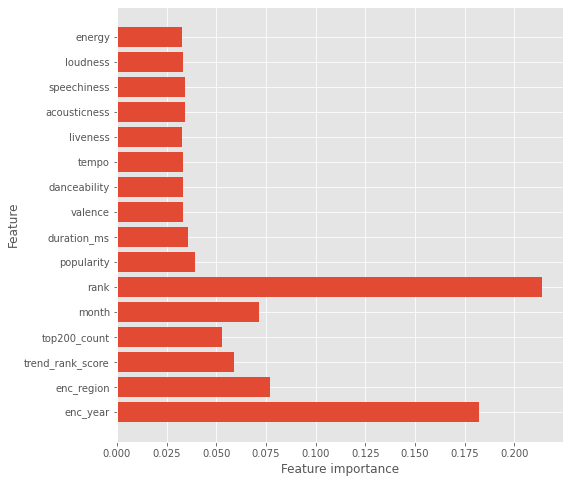

In [79]:
plot_feature_importances(forest4)

In [80]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

In [82]:
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test)
params = {
    'max_depth': 6,
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'num_class': 4,
    # Set number of GPUs if available   
    'n_gpus': 0
}
bst = xgb.train(params, dtrain)
pred = bst.predict(dtest)
# Confusion matrix and classification report
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

XGBoostError: ignored

In [83]:
model = xgb.XGBClassifier()
param_dist = {"max_depth": [1,2,3,4,5,6,7,10,30,50],
              "min_child_weight" : [1,3,6],
              "n_estimators": [10,20,50,200],
              "learning_rate": [#0.01,0.02,0.03,0.05 
                  0.1,0.16,0.20,0.50],}
grid_search = GridSearchCV(model, param_grid=param_dist, cv = 5, 
                                   verbose=10, n_jobs=-1)
grid_search.fit(X_train, y_train)

grid_search.best_estimator_

model = xgb.XGBClassifier(max_depth=1, min_child_weight=1,  n_estimators=50,\
                          n_jobs=-1 , verbose=1,learning_rate=0.5)
model.fit(X_train,y_train)

Fitting 5 folds for each of 480 candidates, totalling 2400 fits


KeyboardInterrupt: ignored

In [ ]:
grid_search.best_params_

{'learning_rate': 0.1,
 'max_depth': 5,
 'min_child_weight': 6,
 'n_estimators': 20}

In [ ]:
grid_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=5, min_child_weight=6, missing=nan,
              monotone_constraints='()', n_estimators=20, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [ ]:
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test)
params = {
    'max_depth': 5,
    'objective': 'multi:softmax',  # error evaluation for multiclass training
    'num_class': 4,
    'learning_rate':0.1,
}
model=xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=5, min_child_weight=6,
              monotone_constraints='()', n_estimators=20, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)
model.fit(X_train,y_train)
pred=model.predict(X_test)
# Confusion matrix and classification report
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

[23:08:03] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426411619/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[[583  55  10   0]
 [201 116  19   0]
 [ 13  21  72   0]
 [  1   6   6  12]]
              precision    recall  f1-score   support

           0       0.73      0.90      0.81       648
           1       0.59      0.35      0.43       336
           2       0.67      0.68      0.68       106
           3       1.00      0.48      0.65        25

    accuracy                           0.70      1115
   macro avg       0.75      0.60      0.64      1115
weighted avg       0.69      0.70      0.68      1115

